# Quality Control for Internal Reference Scaling (IRS) experiments

## Phillip Wilmarth, OHSU

### December 23, 2018

---

## Background information

#### In this notebook you will learn:

- why we need Internal Reference Scaling (IRS)
- that IRS is **not** tolerant of mistakes in sample labeling
- what data characteristics can be leveraged for quality control
- what visualizations and metrics are most useful for QC
- how to make an R function to facilitate QC

---
  
### What is IRS and why do we need it?

If we label the same sample in more than one channel in an isobaric labeling experiment (one labeling kit will be called a "plex" to avoid confusion with "run" or "experiment") and perform basic data normalizations, we will see that the measurement values for those technical replicate channels at any level (PSM, peptide, or protein) are very nearly identical.

Many experiments can have more samples than what will fit into a single plex and more than one plex will need to be used. What happens when we have technical replicates in different plexes? If we do basic normalizations (matching median intensities or total intensities), we will find that we **do not** get similar intensity measurements of technical replicates between plexes (see [IRS validation notebook here]()). 

The overall reporter ion intensities depend not only on the abundance of the peptide, but on when the peptide was "sampled" for fragmentation. The fragmentation scans that provide the peptide sequence and the reporter ion signals are a few 10s to 100s of milliseconds in duration. The extracted ion chromatograms (XIC) of peptides typically have peak widths of many 10s of seconds. If the fragmentation scan occurs at the apex of the XIC, the report ions will be more intense that from fragmentation scans taken at other points along the XIC (such as near the baseline). See Liu et al. 2004 for more on this pseudo-random MS2 sampling effect.  

The IRS method, described in Plubell et al. 2017, is mathematically simple. It will remove pseudo-random MS2 sampling between TMT plexes when given one or more channels to use as references. The diagram below shows a case for 3 plexes with duplicate reference channels in each plex. Using pools of all samples as a master mix is a good way to make the reference channels. 

![IRS Method](https://pwilmart.github.io/TMT_analysis_examples/irs_diagram.png)

The basic concept is that something identical (the standards) was measured in each plex and the resulting measurements for each protein should be the same in each plex. The IRS algorithm will make the standards the same in each plex. The same IRS factors that are applied to the standards in each plex are applied to the other 8 channels in that plex (the 8 biological sample channels in each plex are not shown in the diagram above). This puts all of the TMT channels on the same intensity scale across all of the plexes in the experiment.  An important point is that the data used to determine the IRS factors are independent of the biological sample data.

### Sample-to-channel record keeping is critical

A key feature of isobaric labeling is that the tags are hidden from the mass spectrometer until the peptide is broken apart. Unfortunately, sample information is also hidden from some common ways to keep track of samples. When an LC run corresponds to one sample (or fractions of one sample), the sample information can be embedded in the run/file name. There is no practical way to explicitly embed TMT sample-to-channel names into run lists or RAW filenames. Meticulous record keeping is necessary to track which TMT channels in each TMT-plex are associated with particular samples.

What would happen if we accidently told the IRS algorithm the **wrong** channels for the internal standards? Much like the [honey badger](https://www.randallshoneybadger.com/), IRS don't care (unimportant pop cultural reference circa 2011). The diagram above illustrates the basic steps to the IRS method and the mathematical steps will work exactly the same given **any channels** you pick for the reference standards. 

The results will be really **screwed up** if you specify the wrong standard channels in the IRS method. It is **SUPER IMPORTANT** to know which channels are the true internal standard channels. The method will make the average of the channels selected as the standards perfectly identical between plexes after IRS normalization. There is no way to tell from the standard channels themselves, after IRS, if those were the right channels. Even if the channels were very different to begin with, their average will still end up identical to the average of standards in all of the other plexes. A potential screw up in sample labels **might** be apparent from cluster views of the biological samples, or from unexpected statistical testing results (such as no differential expression results). It would be much better to have a way to check things ahead of time rather than hope for the best afterwards.    

If you are performing the IRS method as described in Plubell et al. 2017, there will be two identical standards in each TMT-plex. Two reference channels are recommended because an average of two measurements will greatly improve the accuracy of the IRS corrections. In addition, the similarity of those two channels makes it possible to try and find them without having any knowledge of the sample key. This is a compelling arguement for using two channels for standards. 

> Liu, H., Sadygov, R.G. and Yates, J.R., 2004. A model for random sampling and estimation of relative protein abundance in shotgun proteomics. Analytical chemistry, 76(14), pp.4193-4201.

> Plubell, D.L., Wilmarth, P.A., Zhao, Y., Fenton, A.M., Minnier, J., Reddy, A.P., Klimek, J., Yang, X., David, L.L. and Pamir, N., 2017. Extended multiplexing of tandem mass tags (TMT) labeling reveals age and high fat diet specific proteome changes in mouse epididymal adipose tissue. Molecular & Cellular Proteomics, 16(5), pp.873-890.
 

### Can we find the pooled standards without knowing the sample key?

We will see if we can load in the raw TMT data and have the computer find the pairs of pooled standard channels automatically. We want a robust, general method to find the closest channels to each other and visualize the results. We will be using the data from Plubell et al. 2017 processed with the [PAW pipeline](https://github.com/pwilmart/PAW_pipeline.git). There were four TMT 10-plexes used in the experiment.

Some playing around was already done before this was written up because your time is valuable. If we have a 10-plex experiment, we will have a grid of 10x10 scatter plots. That is 100 pairs to explore. We do not care about the 10 diagonal comparisons (each channel to itself). That leaves 90. This is a symmetric problem, so we can cut that number in half.  so we really have 45 pairs to consider. That is still a lot. A method (outlined below) to find a few likley pairs was worked out. The extra pairs are mostly to verify that one true best pair was really found.

### Workflow overview
- load data and get TMT columns
  - read data file
  - drop contaminants and decoys
  - subset TMT channels from each plex
- run "find_best_pair" function:
  - perform sample loading corrections and simplify column names
    - make the grand totals of each channel the same
    - use short numerical names for the channels
  - compare channels to each other and find close pairs
    - computer stadardized difference for each channel pair 
    - compute interquartile range (IQR) for each standardized difference vector
    - find the top-N pairs that have the smallest IQRs
  - summarize and visualize results
    - print best pairs
    - print IQR grid
    - IQR distributions of best pairs
    - scatter plots of best pair channels  
    
---
### Load the R libraries

In [3]:
# library imports
library(tidyverse)
library(stringr)
library(limma)
library(psych)
library(Matrix)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
“package ‘limma’ was built under R version 3.5.1”
Attaching package: ‘psych’

The following objects are masked from ‘package:ggplot2’:

    %+%, alpha


Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand



## Load the PAW grouped protein file
This can be either the grouped protein file or the labeled file (for reading by the IRS script). We have inspected the file using Excel and determined that the main table has 4437 rows (not counting the header row).

> Aside: figure out how to read the data files in R without having to see how long they are beforehand...

In [4]:
# load the raw data: the table starts in Row 5
# there are extra lines at the bottom - need to stop before the end
data_import <- read_tsv("PAW_labeled_grouped_protein_summary_TMT_8.txt", 
                        skip = 4, n_max = 4437, guess_max = 4437)

# the "Filter" column flags contams and decoys
data_all <- filter(data_import, is.na(Filter))

# check number of rows before and after filtering
print("Table lengths before and after filtering:")
cat(nrow(data_import), nrow(data_all))

Parsed with column specification:
cols(
  .default = col_double(),
  Accession = col_character(),
  Identical = col_character(),
  Similar = col_character(),
  OtherLoci = col_character(),
  Filter = col_character(),
  Coverage = col_character(),
  SeqLength = col_character(),
  MW = col_character(),
  Description = col_character()
)
See spec(...) for full column specifications.


[1] "Table lengths before and after filtering:"
4437 4350

### Extract the raw data for each TMT-plex
We need a data frame for each TMT-plex that we are checking. The number of columns in the data frame is used to determine the number of channels in the experiment.

In [5]:
# make a data frame for each TMT-plex (and drop zeros)
get_data <- function(df, substring) {
    # extracts PAW TMT columns containing a substring
    
    # df: data frame of PAW results
    # substring: a text substring that defines one TMT-plex
    
    # get the columns
    df <- df %>%
      select(starts_with("TotInt")) %>% 
      select(contains(substring))
    
    # drop rows with zeros
    df[apply(df, 1, function(row) all(row !=0 )), ] # return filtered frame
}

# get each experiment and set column names to something easy to parse
A_raw <- get_data(data_all, "_A_")
B_raw <- get_data(data_all, "_B_")
C_raw <- get_data(data_all, "_C_")
D_raw <- get_data(data_all, "_D_")

## Let's create a function to make checking the data easier 
We do not need any knowledge of which channels are in what groups to correct for basic protocol variation (protein and peptide assays, digestion, labeling, SepPak steps). We can safely do this sample loading normalization step with no prior knowledge of the sample key. We will do this normalization step and also simplify the channel names in one helper function. We will also make standardized difference helper function that takes a data frame and two column indexes as input and returns a vector of differences.

Another helper function will make an interquartile range (IQR) grid of standardized differences for all channels against all channels. The main "find_best_pair" function will extract the top-N smallest IQR values from the grid, determine the associated pair indices, make channel versus channel scatter plots, and make box plots of the IQR distributions. The next cell has the function definitions.

In [6]:
# automatically find closest channel pairs

SL_norm <- function(df, suffix, print_factors = TRUE) {
    # Normalizes each channel's sum to the average grand total
        # df: data frame of TMT data (one column for each channel)
        # suffix: a text string to append to 1-to-n numbers for column names
        # print_factors: logical to control printing
    
    # compute norm factors and scale columns
    norm_facs <- mean(c(colSums(df))) / colSums(df)
    df_sl  <- sweep(df, 2, norm_facs, FUN = "*")
    
    # simplify column names
    colnames(df_sl) <- str_c(as.character(1:ncol(df)), suffix)
    
    # print the normalization factors for QC check
    if (print_factors == TRUE) {
        cat("\nNormalization Factors: ", suffix, "\n ")
        cat(sprintf("%s - %0.3f\n", colnames(df), norm_facs))
    }
    
    df_sl # return normalized data
}

diff <- function(df, x, y) {
    # computes a standardized difference between two vectors
        # df: data frame that contains x and y
        # x: index of first column
        # y: index of second column
    
    # compute the difference and set the column name
    diff <- 100 * abs(df[x] - df[y]) / rowMeans(df[c(x, y)])
    colnames(diff) <- sprintf("%d_%d", x, y)
    
    diff # return difference vector
}

iqr_grid <- function(df, print_grid = TRUE) {
    # computes an NxN grid of interquartile ranges of diffs    
         # df: a data frame of TMT data
         # print_grid: logical to control printing
    
    # make an empty matrix ncol-by-ncol
    iqrs  <- matrix(0.0, ncol(df), ncol(df))
    
    # populate an upper diagonal "diff" matrix
    for (i in 1:ncol(df)) {
        for (j in (i+1):ncol(df)) {
            if (j > ncol(df)) {
                break
            }
            iqrs[i, j] <- IQR(diff(df, i, j)[[1]])
        }
    }
    
    # print the grid
    if( print_grid == TRUE) {
        cat("\nInterquartile range grid:\n")
        print(round(iqrs, 2))
    }
    
    iqrs # return the iqr grid
}

find_best_pair <- function(df, nmax, suffix, title) {
    # finds channel pairs having the smallest standardized differences    
        # df: data frame with TMT channels
        # nmax: how many channels/pairs to check
        # suffix: suffix to add to channel labels
        # title: title string to use in plots
    
    # first do SL normalization
    df_sl <- SL_norm(df, suffix)
    
    # compute the ird grid
    iqrs <- iqr_grid(df_sl)
    
    # find the nmax number of smallest IQR values
    # from https://stackoverflow.com/questions/38664241/ranking-and-counting-matrix-elements-in-r
    iqrs_long <- summary(Matrix(iqrs, sparse = TRUE))
    iqrs_ordered <- iqrs_long[order(-iqrs_long[, 3], decreasing = TRUE),]
    candidates <- iqrs_ordered[1, 1] # starting vector of channels
    for (row in 1:nrow(iqrs_long)){
        candidates <- c(candidates, iqrs_ordered[row, 1])
        candidates <- c(candidates, iqrs_ordered[row, 2])
    }
    
    # get the set of indexes and print the best pairs
    for (pair in 1:nmax) {
        top_n <- sort(unique(candidates)[1:nmax])
        i <- iqrs_ordered[pair, 1]
        j <- iqrs_ordered[pair, 2]
        cat(sprintf("\nPair #%d: (%d, %d) => %0.2f", pair, i, j, iqrs[i, j]))
    }
    
    # make the box plots for the top-n pairs
    distributions <- list()
    for (row in 1:nmax){
        distributions[[row]] <- diff(df_sl, iqrs_ordered[row, 1], iqrs_ordered[row, 2])
    }
    boxplot(do.call(cbind, distributions), main = title)
    
    # multi-panel scatter plots for the top-n channels
    cat(pairs.panels(log10(df_sl[top_n]), lm = TRUE, main = title))
}

# Find the standard channel pair for Experiment A 


Normalization Factors:  _A 
 TotInt_126C_PAMI_GMCSF_A_TMT_20161027 - 0.903
 TotInt_127N_PAMI_GMCSF_A_TMT_20161027 - 0.981
 TotInt_127C_PAMI_GMCSF_A_TMT_20161027 - 0.948
 TotInt_128N_PAMI_GMCSF_A_TMT_20161027 - 1.090
 TotInt_128C_PAMI_GMCSF_A_TMT_20161027 - 1.010
 TotInt_129N_PAMI_GMCSF_A_TMT_20161027 - 1.034
 TotInt_129C_PAMI_GMCSF_A_TMT_20161027 - 1.012
 TotInt_130N_PAMI_GMCSF_A_TMT_20161027 - 0.992
 TotInt_130C_PAMI_GMCSF_A_TMT_20161027 - 1.001
 TotInt_131N_PAMI_GMCSF_A_TMT_20161027 - 1.055

Interquartile range grid:
      [,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10]
 [1,]    0 36.23 24.77 24.54 22.23 26.11 32.22 24.48 38.86 30.35
 [2,]    0  0.00 35.63 34.45 33.91 27.89 30.78 26.49 23.91 37.98
 [3,]    0  0.00  0.00 26.65 27.17 25.34 35.99 25.23 36.57 31.72
 [4,]    0  0.00  0.00  0.00 16.70 18.54 26.06 19.05 31.69 36.03
 [5,]    0  0.00  0.00  0.00  0.00 16.47 21.30 16.65 28.89 35.44
 [6,]    0  0.00  0.00  0.00  0.00  0.00 18.55  8.26 22.52 32.33
 [7,]    0  0.00  0

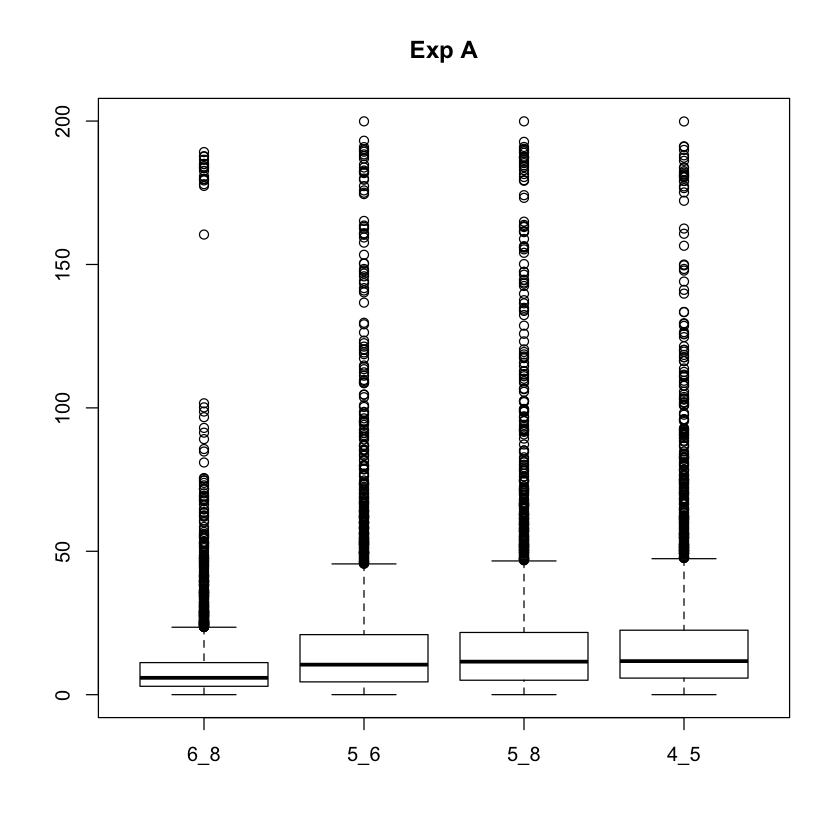

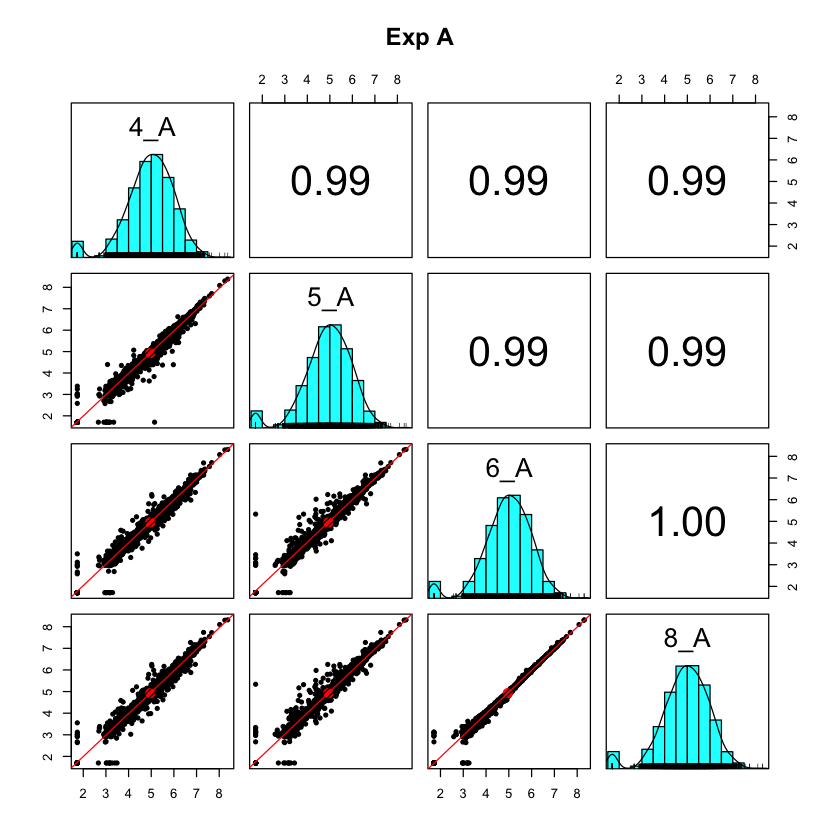

In [7]:
# nmax is how many top pairs to consider (3 or 4 are recommended values)
top_n <- 4

# find the standards in experiment A
# this is now a one-line function call
find_best_pair(A_raw, top_n, "_A", "Exp A")

## Check the other 3 plexes


Normalization Factors:  _B 
 TotInt_126C_PAMI_GMCSF_B_TMT_20161028 - 0.902
 TotInt_127N_PAMI_GMCSF_B_TMT_20161028 - 1.085
 TotInt_127C_PAMI_GMCSF_B_TMT_20161028 - 0.953
 TotInt_128N_PAMI_GMCSF_B_TMT_20161028 - 1.028
 TotInt_128C_PAMI_GMCSF_B_TMT_20161028 - 1.160
 TotInt_129N_PAMI_GMCSF_B_TMT_20161028 - 1.019
 TotInt_129C_PAMI_GMCSF_B_TMT_20161028 - 1.042
 TotInt_130N_PAMI_GMCSF_B_TMT_20161028 - 0.994
 TotInt_130C_PAMI_GMCSF_B_TMT_20161028 - 0.994
 TotInt_131N_PAMI_GMCSF_B_TMT_20161028 - 0.883

Interquartile range grid:
      [,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10]
 [1,]    0 25.16 15.40 25.13 18.77 22.47 31.94 30.10 32.15 24.83
 [2,]    0  0.00 22.12 26.52 23.29 20.02 39.28 33.58 34.17 34.73
 [3,]    0  0.00  0.00 26.11  7.40 18.15 31.15 30.61 24.00 24.10
 [4,]    0  0.00  0.00  0.00 25.91 30.51 42.74 36.52 41.87 35.70
 [5,]    0  0.00  0.00  0.00  0.00 17.64 29.56 29.28 22.43 23.61
 [6,]    0  0.00  0.00  0.00  0.00  0.00 33.45 33.71 26.35 27.67
 [7,]    0  0.00  0

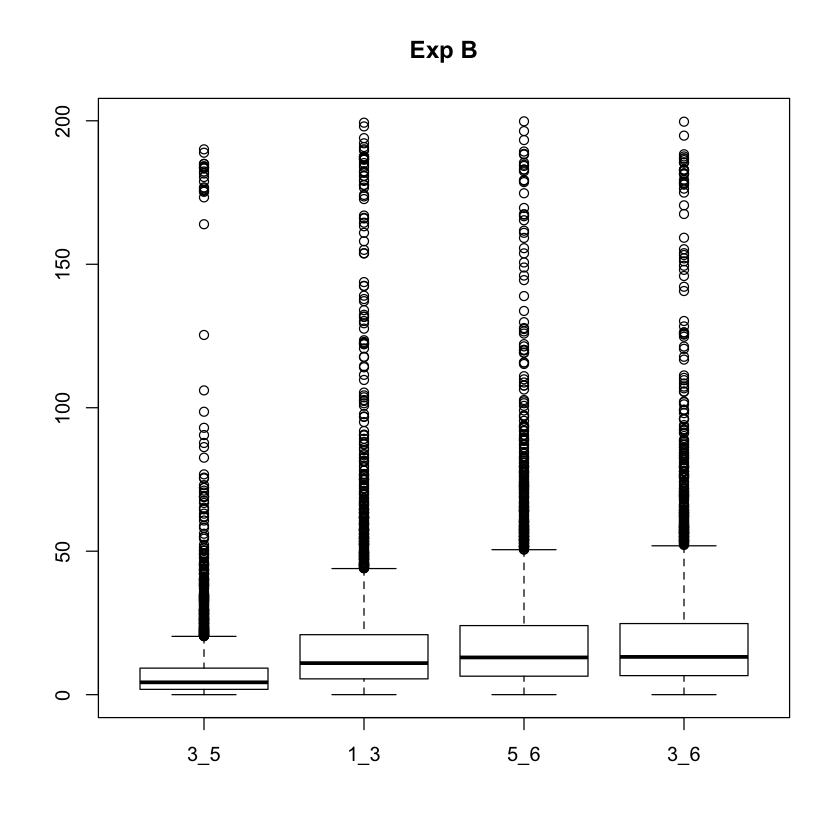

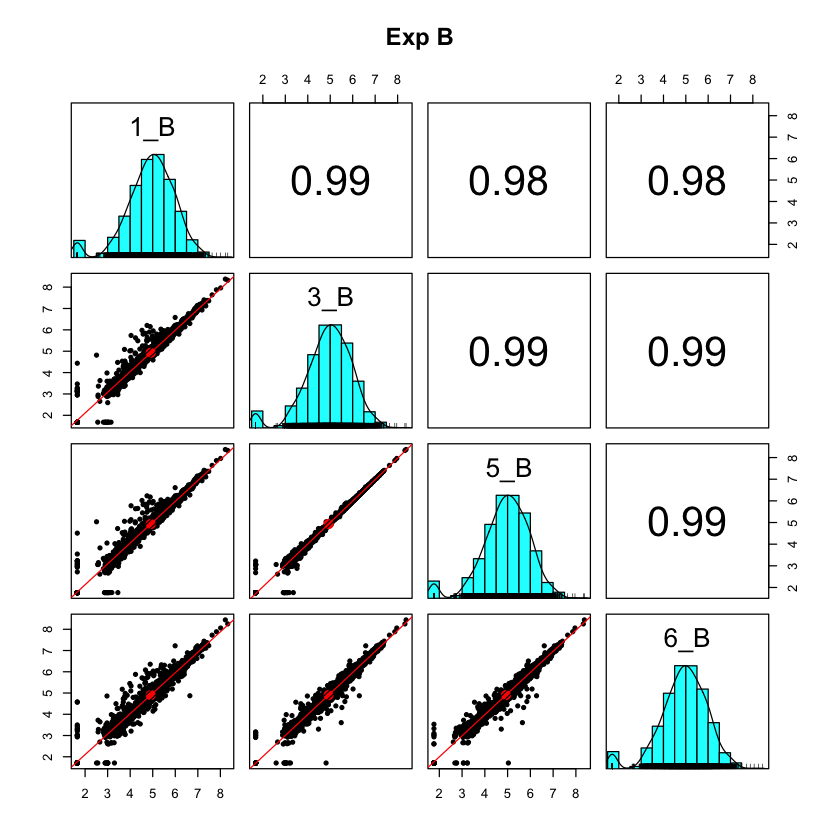

In [8]:
# experiment B
find_best_pair(B_raw, top_n, "_B", "Exp B")


Normalization Factors:  _C 
 TotInt_126C_PAMI_GMCSF_C_TMT_20161031 - 0.888
 TotInt_127N_PAMI_GMCSF_C_TMT_20161031 - 1.050
 TotInt_127C_PAMI_GMCSF_C_TMT_20161031 - 1.089
 TotInt_128N_PAMI_GMCSF_C_TMT_20161031 - 1.038
 TotInt_128C_PAMI_GMCSF_C_TMT_20161031 - 1.023
 TotInt_129N_PAMI_GMCSF_C_TMT_20161031 - 0.946
 TotInt_129C_PAMI_GMCSF_C_TMT_20161031 - 1.009
 TotInt_130N_PAMI_GMCSF_C_TMT_20161031 - 1.073
 TotInt_130C_PAMI_GMCSF_C_TMT_20161031 - 0.978
 TotInt_131N_PAMI_GMCSF_C_TMT_20161031 - 0.944

Interquartile range grid:
      [,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10]
 [1,]    0 17.92 18.71 20.98 23.52 18.28 17.87 29.15  7.01 25.30
 [2,]    0  0.00 25.07 28.89 29.12 21.60 26.81 35.92 19.32 33.66
 [3,]    0  0.00  0.00 30.80 20.38 27.89 29.65 39.54 20.50 32.48
 [4,]    0  0.00  0.00  0.00 31.45 21.52 23.62 28.34 22.08 20.20
 [5,]    0  0.00  0.00  0.00  0.00 32.22 30.47 38.76 25.09 30.30
 [6,]    0  0.00  0.00  0.00  0.00  0.00 21.97 30.68 17.50 29.16
 [7,]    0  0.00  0

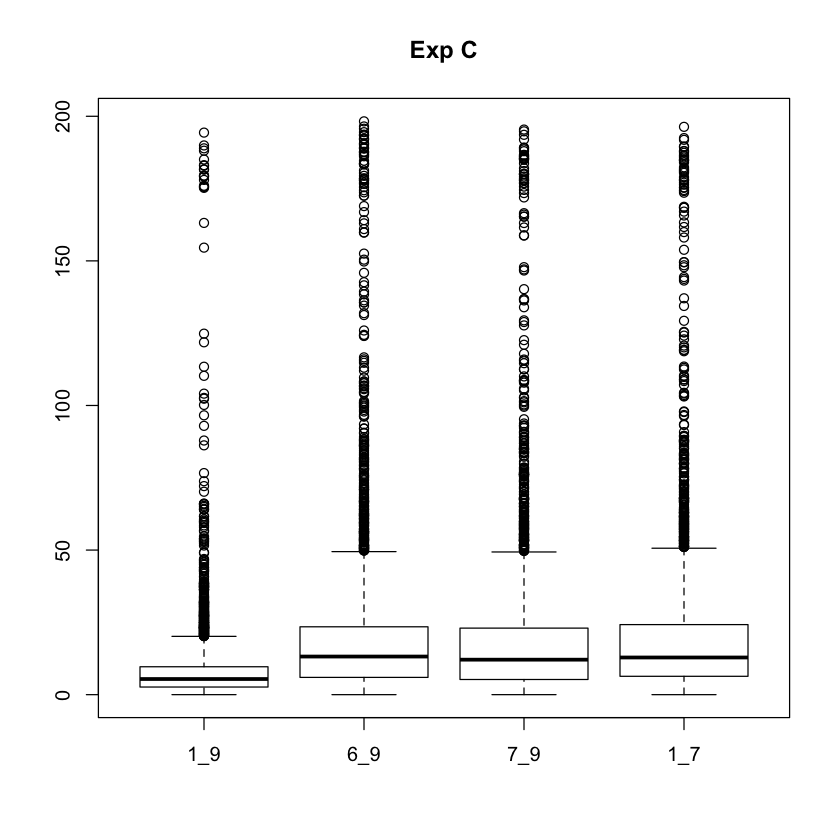

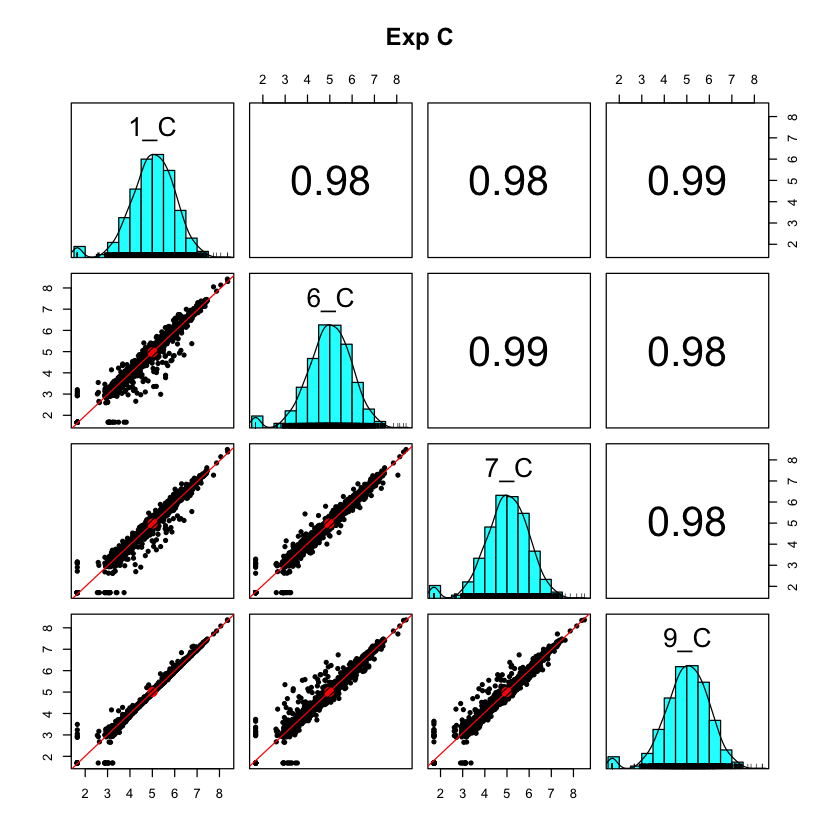

In [9]:
# experiment C
find_best_pair(C_raw, top_n, "_C", "Exp C")


Normalization Factors:  _D 
 TotInt_126C_PAMI_GMCSF_D_TMT_20161101 - 0.849
 TotInt_127N_PAMI_GMCSF_D_TMT_20161101 - 1.129
 TotInt_127C_PAMI_GMCSF_D_TMT_20161101 - 1.075
 TotInt_128N_PAMI_GMCSF_D_TMT_20161101 - 1.117
 TotInt_128C_PAMI_GMCSF_D_TMT_20161101 - 1.036
 TotInt_129N_PAMI_GMCSF_D_TMT_20161101 - 0.908
 TotInt_129C_PAMI_GMCSF_D_TMT_20161101 - 1.130
 TotInt_130N_PAMI_GMCSF_D_TMT_20161101 - 0.895
 TotInt_130C_PAMI_GMCSF_D_TMT_20161101 - 1.010
 TotInt_131N_PAMI_GMCSF_D_TMT_20161101 - 0.951

Interquartile range grid:
      [,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10]
 [1,]    0 21.97 30.62 23.96 22.20 12.96 21.67 27.60 26.03 20.51
 [2,]    0  0.00 18.91 15.52 13.30 22.43  6.97 23.40 17.24 16.96
 [3,]    0  0.00  0.00 23.10 23.34 32.39 19.26 26.87 20.26 24.96
 [4,]    0  0.00  0.00  0.00 17.34 24.51 16.24 15.87 25.42 20.01
 [5,]    0  0.00  0.00  0.00  0.00 25.30 12.93 25.44 21.60 22.05
 [6,]    0  0.00  0.00  0.00  0.00  0.00 22.77 26.74 29.39 23.36
 [7,]    0  0.00  0

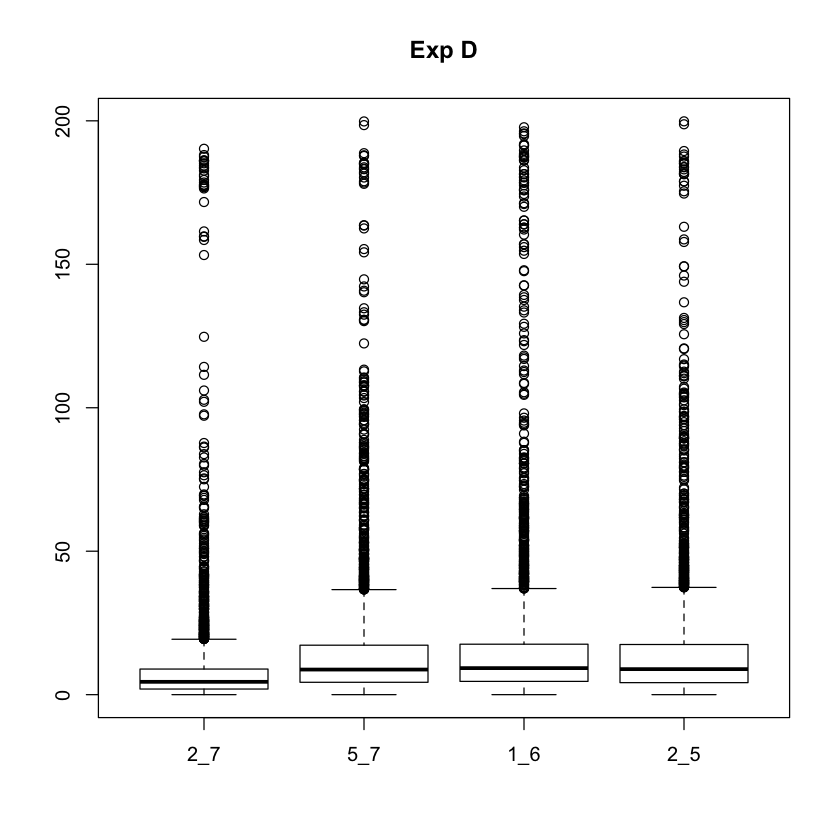

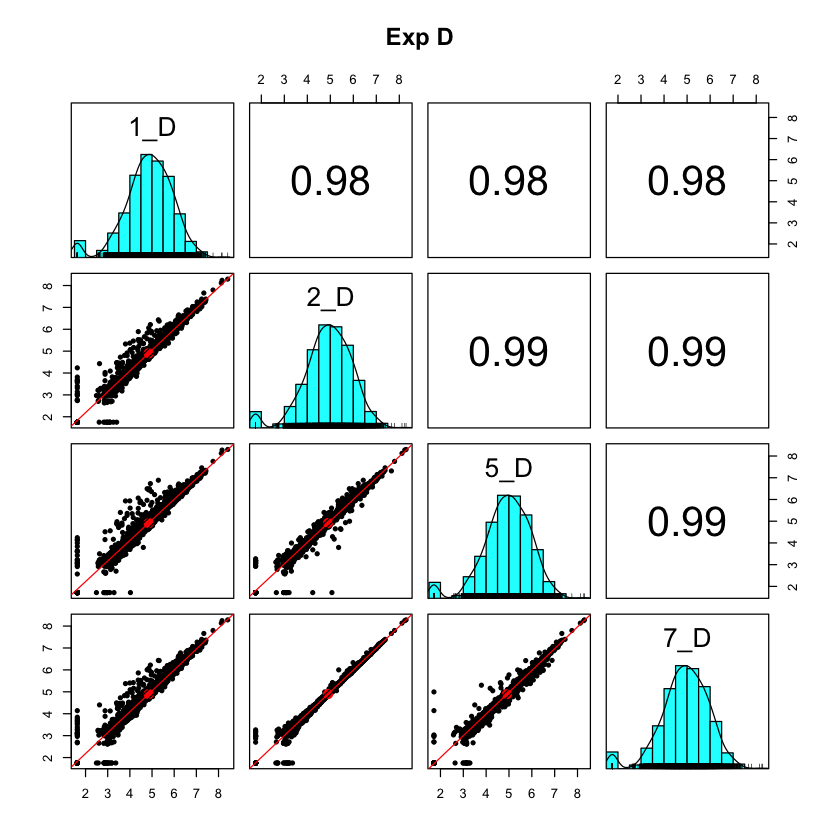

In [10]:
# and experiment D
find_best_pair(D_raw, top_n, "_D", "Exp D")

## Conclusion and comments

Here is a summary of our results:

- Best Pair A: (6, 8) => 8.26
- Best Pair B: (3, 5) => 7.40
- Best Pair C: (1, 9) => 7.01
- Best Pair D: (2, 7) => 6.97

Those were, in fact, the correct channels for the pooled standards. They were randomly allocated to different channels in each TMT plex. These difficult-to-work-with adipose tissue samples had a lot of sample-to-sample variability, so finding the pairs of standards was pretty easy. They were really obvious to spot. This procedure is pretty easy to do, so it is probably a good quality control check to routinely do.

---

## What is the back story to developing the "find_best_pair" function?

We have used MDS clustering plots and multi-panel scatter plots for QC in other notebooks. Did we really need an all-in-one function?

### See what the cluster plots tells us

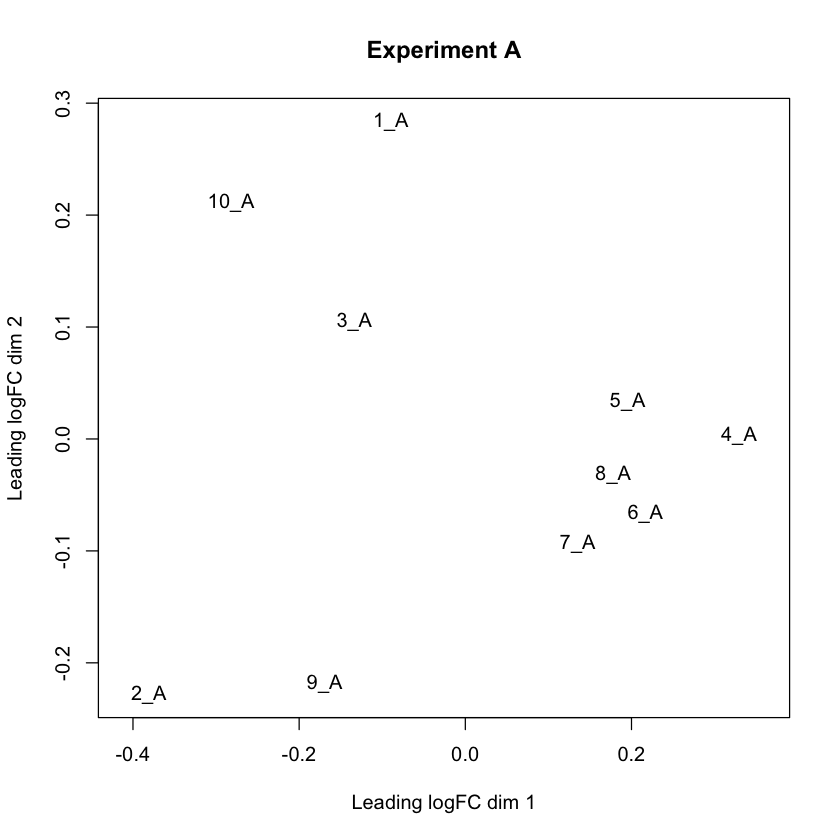

In [11]:
# check the clustering
A_sl <- SL_norm(A_raw, "_A", print_factors = FALSE)
plotMDS(log10(A_sl), main = "Experiment A")

### The 6 and 8 pair are closest, but they do not jump out at you
7 is also close to (6, 8) and so is 5. How many possibilities should we consider?

### We could also have done a larger scatter plot matrix
If we are not sure how many channels to consider, maybe we should just look at all of them.

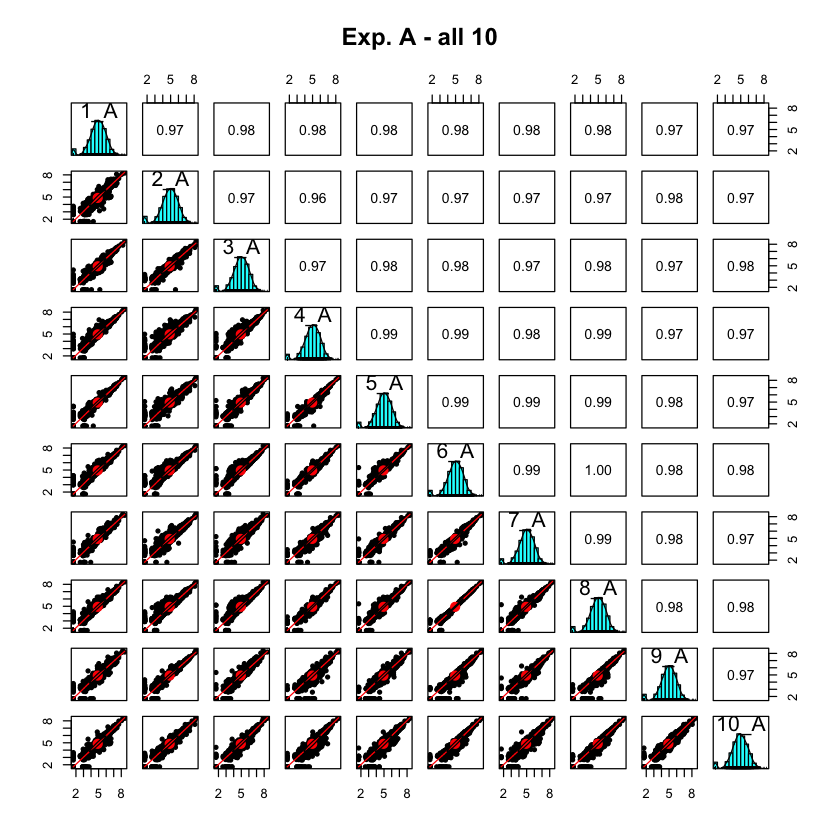

In [12]:
pairs.panels(log10(A_sl), main = "Exp. A - all 10")

### Scatter plots are too small for 10x10 or 11x11 grids 

When we have the full grid, the plots are pretty small and there are a lot of them to examine. Finding a smaller set of channels to look at in larger multi-panel plots was better.

#### The "making of the find_best_pair function" bonus feature
##### Trial and error first steps
The progression to the automated pair finding function above went something like this: The scatter plots for pairs of identical channels are really similar (tight to the diagonal) in isobaric labeling. They should be easy to spot in scatter plot grids, so make a grid for all channels in a TMT plex (10 or 11 mostly). I like the plots in log-log for axes scales so there cannot be any zeros in the data. Better add a filter step after reading in the data. I might need to worry about zeros in a more careful way with real data analysis, but here we can drop a few proteins and it should not affect things. Okay, that is fixed, and we can make the plots. Hmmm. Plots are small and there are a lot of them. 

##### Are MDS plots useful?
Maybe the MDS plots can help find "close" pairs. The clustering might be better if some variation in the data was first removed. We do not need to know the sample key when doing the sample loading normalization so can do that first and then play with the within-TMT normalized data for all subsequent steps. The MDS plots need log transformed data. The channel labels with TMT tag designations, etc. are too long. The labels make it hard to see the clusters. Maybe some simplified channel labels would be better. Let's add that after the sample loading normalization. The pairs of standards tend to be pretty close together, but they are not super obvious. The cluster plots were okay to find a few channels to restrict the multi-panel scatter plots to. Larger scatter plots with fewer channels are much easier to interpret. 

##### What about something like CV distributions?
Distributions of CV values are also useful data views. CVs are small when samples are consistent. We would expect identical samples to have very small CVs. We only have one pair of identical channels (two data values per protein). That is not great for a standard deviation calculation. Maybe we can substitute the absolute value of the difference for the standard deviation. Making some box plots of those distributions looked pretty useful.

##### Too many steps by hand is tedious
Okay. Looking at busy scatter plot grids and MDS cluster plots, manually picking some candidate channels, and then looking at those in more details is kind of tedious. And it rapidly gets much more tedious as the number of plexes to check goes up. Is there some way to automate all of this? Scatter plot grids are human scannable for the best plot. We need something numerical in an appropriate data structure if we want to have R do it for us. The box plots of the difference distributions have medians and interquartile ranges that can be used as single values to define the distributions. We can stick those number is a 10x10 or 11x11 matrix. If we can find the smallest value in the matrix and figure out its indices, then we have a method to find the best pair.

I like to double check everything I can every single time I can. I do not trust algorithms, even the algorithms that I write. I do not know everything. I have not analyzed all possible data. There might be something I have not anticipated, and I should always be on the lookout for something unexpected. That is how discoveries are made. You do not get grant money to work on things that are already understood. Ideally, I want to see the best pair **and** a few other pairs to compare things to. We will automate finding the **top N pairs** and look at the data and views for that subset of channels.

##### Clean up function code and documentation
Once that was worked out in principle, then it was refactoring code so that the whole process could be a one-line function call. Breaking things up into several smaller functions is also good. This can allow more code reuse later. It seems that the coding practices in R are to completely separate documentation from code. I am not sure why that seems to be an R best practice. Maybe the strange, near complete separation of using functions from writing functions has something to do with it. Why document the code inside the function if no one will ever see it? However, the most important person you write documentation for is your future self. In notebooks, the code is designed to be looked at, so I tried to adopt some sensible commenting of the functions.

##### Make a copy of this notebook and play with your data!
Notebooks are a great format for playing with data. You can explore ideas to see what works and does not work. A lot of data analysis is trial and error. Many things sound great over that second or third beer, but no not work so well in practice. Most data analysis is just application of a few basic concepts. One does not really have to be so dependent on other people writing packages and functions. That is why I wrote this function for you! Ha-ha.

In [13]:
# log the session
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-apple-darwin15.6.0 (64-bit)
Running under: macOS  10.14.2

Matrix products: default
BLAS: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2.2  Matrix_1.2-15   psych_1.8.10    limma_3.38.3   
 [5] forcats_0.3.0   stringr_1.3.1   dplyr_0.7.8     purrr_0.2.5    
 [9] readr_1.3.1     tidyr_0.8.2     tibble_1.4.2    ggplot2_3.1.0  
[13] tidyverse_1.2.1

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 repr_0.18        haven_2.0.0     
 [5] lattice_0.20-38  colorspace_1.3-2 generics_0.0.2   htmltools_0.3.6 
 [9] base64enc_0.1-3  rlang_0.3.0.1    pillar_1.3.1     foreign_0.8-71  
[13] glue_1.3